In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_selection import SelectKBest, chi2

# Download necessary NLTK data
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')  # Download for lemmatizer

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\EndUser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\EndUser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\EndUser\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [21]:
# Load dataset
df = pd.read_csv('Mental-Health-Twitter.csv')
print(df)

       Unnamed: 0             post_id                    post_created  \
0               0  637894677824413696  Sun Aug 30 07:48:37 +0000 2015   
1               1  637890384576778240  Sun Aug 30 07:31:33 +0000 2015   
2               2  637749345908051968  Sat Aug 29 22:11:07 +0000 2015   
3               3  637696421077123073  Sat Aug 29 18:40:49 +0000 2015   
4               4  637696327485366272  Sat Aug 29 18:40:26 +0000 2015   
...           ...                 ...                             ...   
19995       19995  819336825231773698  Thu Jan 12 00:14:56 +0000 2017   
19996       19996  819334654260080640  Thu Jan 12 00:06:18 +0000 2017   
19997       19997  819334503042871297  Thu Jan 12 00:05:42 +0000 2017   
19998       19998  819334419374899200  Thu Jan 12 00:05:22 +0000 2017   
19999       19999  819334270825197568  Thu Jan 12 00:04:47 +0000 2017   

                                               post_text     user_id  \
0      It's just over 2 years since I was diagnosed

In [22]:
# Drop unnecessary columns
df.drop(["Unnamed: 0", "post_id", "user_id"], axis=1, inplace=True)

# Convert to datetime
df['post_created'] = pd.to_datetime(df['post_created'])
df['month'] = df['post_created'].dt.month
df['year'] = df['post_created'].dt.year
df.drop('post_created', axis=1, inplace=True)

C:\Users\EndUser\AppData\Local\Temp\ipykernel_1448\3198014151.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['post_created'] = pd.to_datetime(df['post_created'])


In [23]:
df.isnull().sum()

post_text     0
followers     0
friends       0
favourites    0
statuses      0
retweets      0
label         0
month         0
year          0
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   post_text   20000 non-null  object
 1   followers   20000 non-null  int64 
 2   friends     20000 non-null  int64 
 3   favourites  20000 non-null  int64 
 4   statuses    20000 non-null  int64 
 5   retweets    20000 non-null  int64 
 6   label       20000 non-null  int64 
 7   month       20000 non-null  int32 
 8   year        20000 non-null  int32 
dtypes: int32(2), int64(6), object(1)
memory usage: 1.2+ MB


In [25]:
df.describe()

,followers,friends,favourites,statuses,retweets,label,month,year
count,20000.000000,20000.000000,20000.000000,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000
mean,900.483950,782.428750,6398.235550,4.439442e+04,1437.927300,0.500000,6.711350,2015.485950
std,1899.913961,1834.817945,8393.072914,1.407785e+05,15119.665118,0.500013,4.735351,1.485434
min,0.000000,0.000000,0.000000,3.000000e+00,0.000000,0.000000,1.000000,2009.000000
25%,177.000000,211.000000,243.000000,5.129000e+03,0.000000,0.000000,1.000000,2015.000000
50%,476.000000,561.000000,2752.000000,1.325100e+04,0.000000,0.500000,8.000000,2016.000000
75%,1197.000000,701.000000,8229.000000,5.289200e+04,1.000000,1.000000,12.000000,2016.000000
max,28614.000000,28514.000000,39008.000000,1.063601e+06,839540.000000,1.000000,12.000000,2017.000000


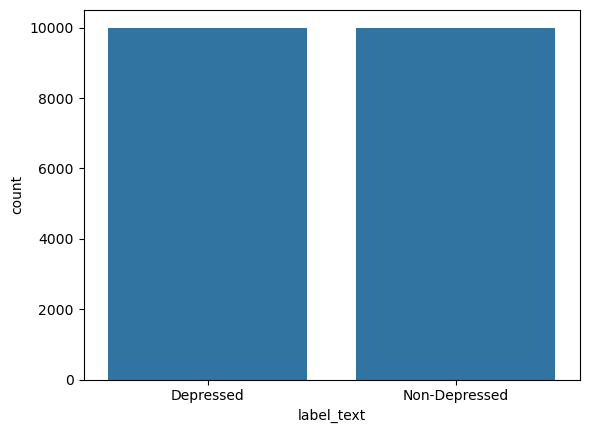

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Map 0 and 1 to 'Non-Depressed' and 'Depressed'
df['label_text'] = df['label'].map({0: 'Non-Depressed', 1: 'Depressed'})

# Plot with the new column
sns.countplot(data=df, x="label_text")

# Display the plot
plt.show()

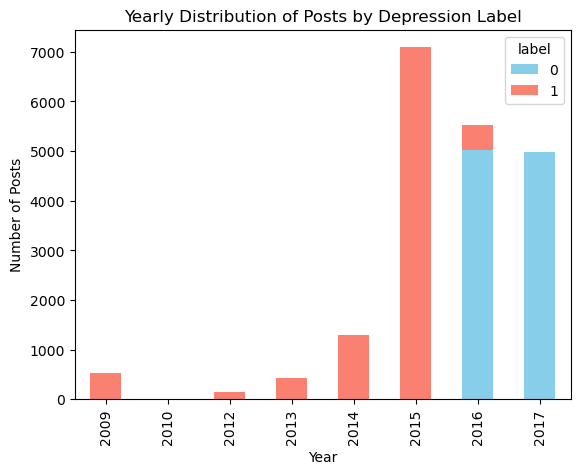

In [27]:
# Group by 'year' and 'label' to count the occurrences of each label per year
yearly_counts = df.groupby(['year', 'label']).size().unstack(fill_value=0)

# Plot the stacked bar chart
yearly_counts.plot(kind='bar', stacked=True, color=['skyblue', 'salmon'])
plt.title('Yearly Distribution of Posts by Depression Label')
plt.xlabel('Year')
plt.ylabel('Number of Posts')
plt.show()

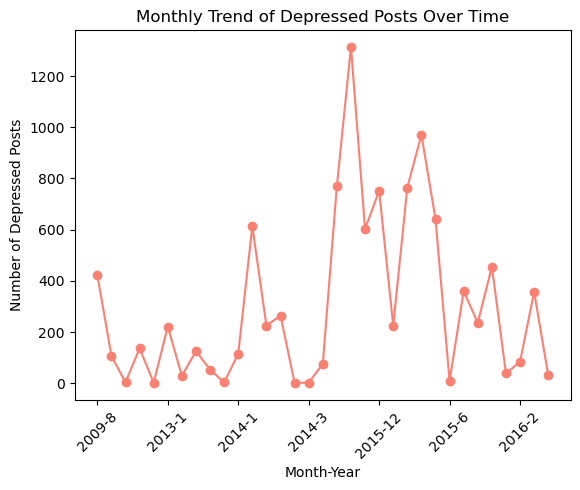

In [28]:
# Create a 'month_year' column combining year and month for grouping
df['month_year'] = df['year'].astype(str) + '-' + df['month'].astype(str)

# Filter the DataFrame for depressed posts (label == 1)
monthly_counts = df[df['label'] == 1].groupby('month_year').size()

# Plot the monthly trend
monthly_counts.plot(kind='line', color='salmon', marker='o')
plt.title('Monthly Trend of Depressed Posts Over Time')
plt.xlabel('Month-Year')
plt.ylabel('Number of Depressed Posts')
plt.xticks(rotation=45)
plt.show()

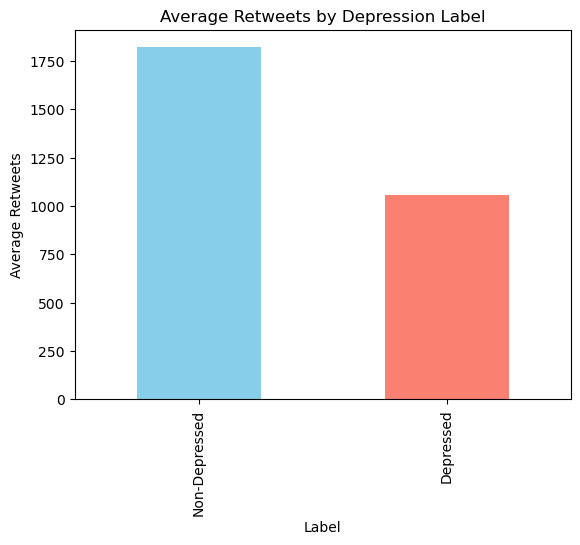

In [29]:
avg_retweets = df.groupby('label')['retweets'].mean()
avg_retweets.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Average Retweets by Depression Label')
plt.xlabel('Label')
plt.ylabel('Average Retweets')
plt.xticks([0, 1], ['Non-Depressed', 'Depressed'])
plt.show()

In [30]:
# Text preprocessing
sw = stopwords.words("english")
custom_stopwords = set(sw) - {"great", "optimistic", "happy", "sad"}  # Customize stopwords

def preprocess_text(text):
    text = " ".join(text.lower() for text in text.split())  # Lowercase
    text = text.replace("\d", "")  # Remove digits
    text = text.replace("[^\w\s!]", "")  # Remove punctuation except '!'
    text = " ".join(x for x in text.split() if x not in custom_stopwords)  # Remove stopwords
    text = " ".join(lemmatizer.lemmatize(word) for word in text.split())  # Lemmatize words
    return text

df['post_text'] = df['post_text'].apply(preprocess_text)

In [31]:
# Apply preprocessing and store in a new column 'processed_text'
df['processed_text'] = df['post_text'].apply(preprocess_text)

# Check the new columns
df[['post_text', 'processed_text']].head()


,post_text,processed_text
0,2 year since diagnosed #anxiety #depression. t...,2 year since diagnosed #anxiety #depression. t...
1,"sunday, need break, i'm planning spend little ...","sunday, need break, i'm planning spend little ..."
2,awake tired. need sleep brain ideas...,awake tired. need sleep brain ideas...
3,rt @sewhq: #retro bear make perfect gift great...,rt @sewhq: #retro bear make perfect gift great...
4,it’s hard say whether packing list making life...,it’s hard say whether packing list making life...


In [32]:
# Sentiment analysis layer in preprocessing
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity

df['sentiment_score'] = df['post_text'].apply(get_sentiment)

# Apply a threshold for sentiment classification in preprocessing
def sentiment_classification(text, sentiment_score):
    if sentiment_score > 0.2:  # Positive sentiment threshold
        return 'Not Depressed'
    return text  # Retain text for further processing if not classified as 'Not Depressed'

df['post_text'] = df.apply(lambda row: sentiment_classification(row['post_text'], row['sentiment_score']), axis=1)

In [33]:
# Display first 5 rows with sentiment scores
df['sentiment_score'] = df['post_text'].apply(get_sentiment)
print(df[['post_text', 'sentiment_score']].head(5))

                                           post_text  sentiment_score
0  2 year since diagnosed #anxiety #depression. t...         0.100000
1  sunday, need break, i'm planning spend little ...        -0.093750
2             awake tired. need sleep brain ideas...        -0.400000
3                                      Not Depressed         0.000000
4  it’s hard say whether packing list making life...        -0.045833


In [44]:
# Define parameters
tfidf_max_features = 500
chi2_k = 500

# Step 1: Vectorize the text using TF-IDF
vectorizer = TfidfVectorizer(max_features=tfidf_max_features)
X = vectorizer.fit_transform(df['processed_text'])

# Step 2: Feature selection using Chi-Square
chi2_selector = SelectKBest(chi2, k=chi2_k)
X_kbest = chi2_selector.fit_transform(X, df['label'])

In [45]:
# Split data into training and testing sets
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X_kbest, y, test_size=0.2, random_state=42)

In [46]:
from imblearn.over_sampling import SMOTE

# Handle class imbalance with SMOTE
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

Decision Tree Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.76      0.78      0.77      1981
    Depressed       0.78      0.76      0.77      2019

     accuracy                           0.77      4000
    macro avg       0.77      0.77      0.77      4000
 weighted avg       0.77      0.77      0.77      4000



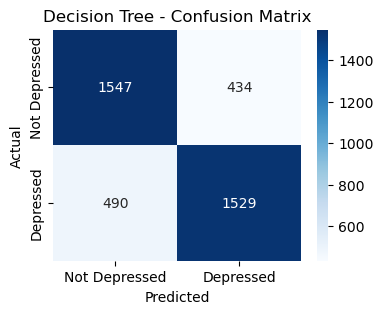

XGBoost Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.81      0.73      0.77      1981
    Depressed       0.76      0.84      0.80      2019

     accuracy                           0.78      4000
    macro avg       0.79      0.78      0.78      4000
 weighted avg       0.79      0.78      0.78      4000



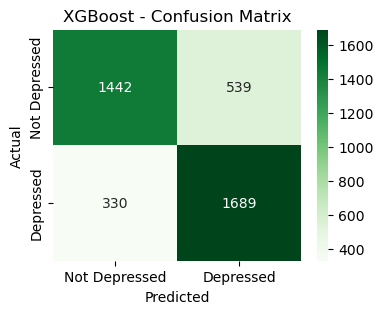

In [47]:
# Train and evaluate Decision Tree
decision_tree_model = DecisionTreeClassifier()
decision_tree_model.fit(X_train, y_train)
y_pred_dt = decision_tree_model.predict(X_test)

accuracy_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt)
recall_dt = recall_score(y_test, y_pred_dt)

print(f"Decision Tree Classification Report:\n{classification_report(y_test, y_pred_dt, target_names=['Not Depressed', 'Depressed'])}")

# Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.title('Decision Tree - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Train and evaluate XGBoost
xgboost_model = XGBClassifier()
xgboost_model.fit(X_train, y_train)
y_pred_xgb = xgboost_model.predict(X_test)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)

print(f"XGBoost Classification Report:\n{classification_report(y_test, y_pred_xgb, target_names=['Not Depressed', 'Depressed'])}")

# Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Greens',
            xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.title('XGBoost - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



SVM Classification Report:
               precision    recall  f1-score   support

Not Depressed       0.77      0.77      0.77      1981
    Depressed       0.77      0.77      0.77      2019

     accuracy                           0.77      4000
    macro avg       0.77      0.77      0.77      4000
 weighted avg       0.77      0.77      0.77      4000



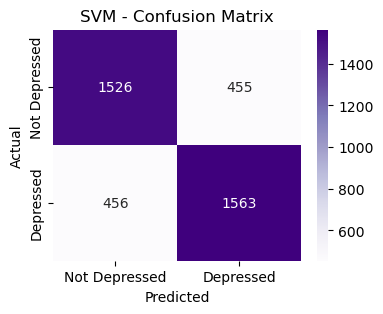

In [48]:


# Train and evaluate SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

accuracy_svm = accuracy_score(y_test, y_pred_svm)
f1_svm = f1_score(y_test, y_pred_svm)
precision_svm = precision_score(y_test, y_pred_svm)
recall_svm = recall_score(y_test, y_pred_svm)

print(f"SVM Classification Report:\n{classification_report(y_test, y_pred_svm, target_names=['Not Depressed', 'Depressed'])}")

# Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Purples',
            xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.title('SVM - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Random Forest - Accuracy: 0.7937
Random Forest - Precision: 0.7890
Random Forest - Recall: 0.8073
Random Forest - F1 Score: 0.7980

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      1981
           1       0.79      0.81      0.80      2019

    accuracy                           0.79      4000
   macro avg       0.79      0.79      0.79      4000
weighted avg       0.79      0.79      0.79      4000



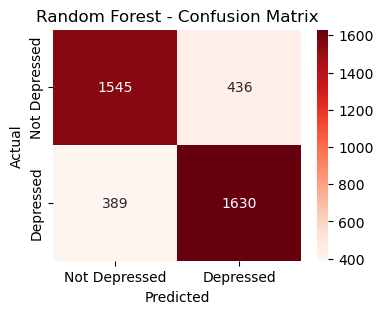

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Assuming you have these variables
# X_train, X_test, y_train, y_test = Preprocessed training and testing data

# Initialize the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='binary')
recall_rf = recall_score(y_test, y_pred_rf, average='binary')
f1_rf = f1_score(y_test, y_pred_rf, average='binary')

# Print evaluation results
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}")
print(f"Random Forest - Precision: {precision_rf:.4f}")
print(f"Random Forest - Recall: {recall_rf:.4f}")
print(f"Random Forest - F1 Score: {f1_rf:.4f}")

# Classification report for Random Forest
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
plt.figure(figsize=(4, 3))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Reds',
            xticklabels=['Not Depressed', 'Depressed'], yticklabels=['Not Depressed', 'Depressed'])
plt.title('Random Forest - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [59]:
# Summary of model performances
print(f"\nPerformance Summary:")
print(f"Decision Tree - Accuracy: {accuracy_dt:.4f}, F1 Score: {f1_dt:.4f}, Precision: {precision_dt:.4f}, Recall: {recall_dt:.4f}")
print(f"XGBoost - Accuracy: {accuracy_xgb:.4f}, F1 Score: {f1_xgb:.4f}, Precision: {precision_xgb:.4f}, Recall: {recall_xgb:.4f}")
print(f"SVM - Accuracy: {accuracy_svm:.4f}, F1 Score: {f1_svm:.4f}, Precision: {precision_svm:.4f}, Recall: {recall_svm:.4f}")
print(f"Random Forest - Accuracy: {accuracy_rf:.4f}, F1 Score: {f1_rf:.4f}, Precision: {precision_rf:.4f}, Recall: {recall_rf:.4f}")


Performance Summary:
Decision Tree - Accuracy: 0.7690, F1 Score: 0.7680, Precision: 0.7789, Recall: 0.7573
XGBoost - Accuracy: 0.7827, F1 Score: 0.7954, Precision: 0.7581, Recall: 0.8366
SVM - Accuracy: 0.7722, F1 Score: 0.7743, Precision: 0.7745, Recall: 0.7741
Random Forest - Accuracy: 0.7937, F1 Score: 0.7980, Precision: 0.7890, Recall: 0.8073


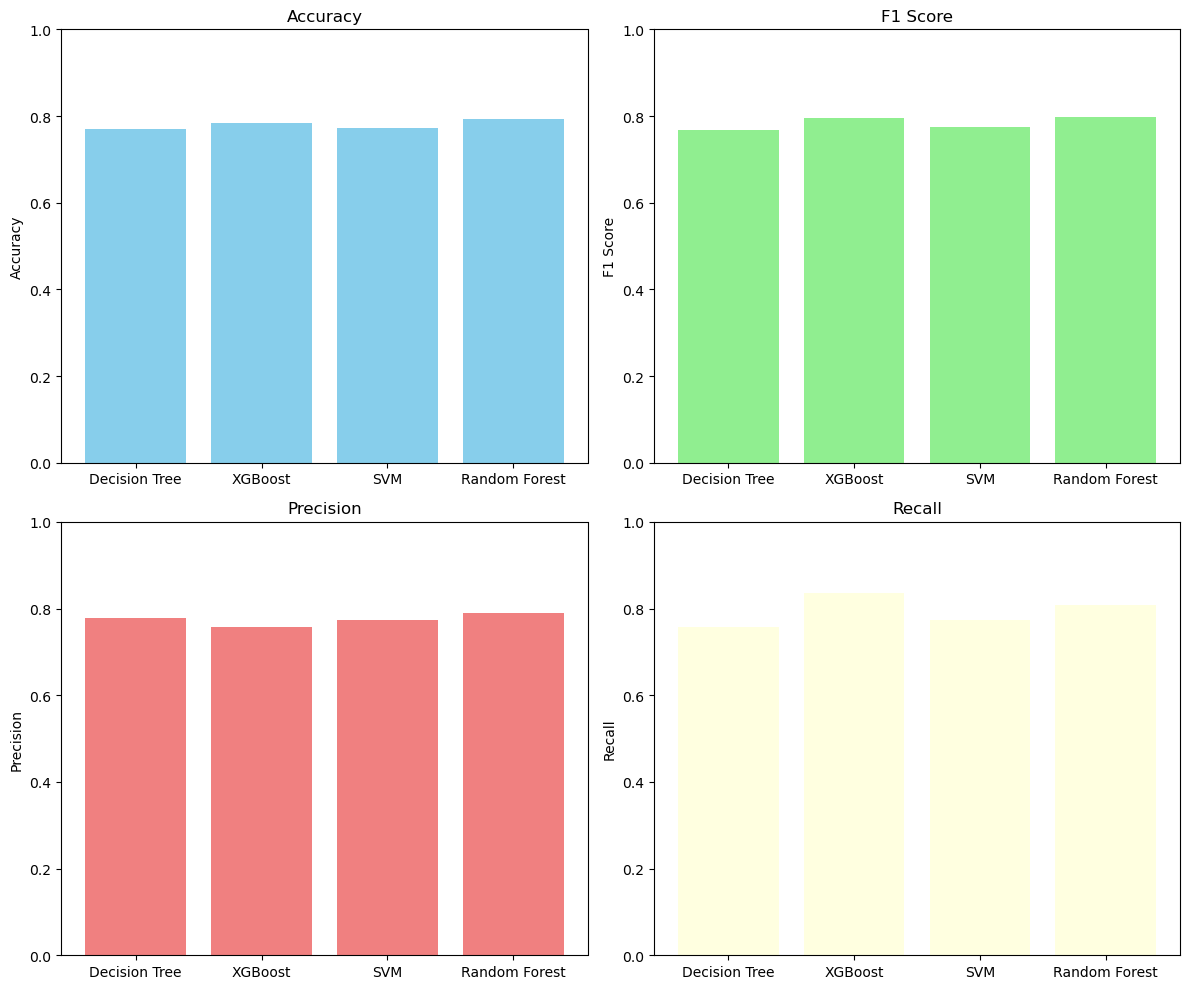

In [65]:
import matplotlib.pyplot as plt

# Performance data for the models
models = ['Decision Tree', 'XGBoost', 'SVM', 'Random Forest']
accuracy = [accuracy_dt, accuracy_xgb, accuracy_svm, accuracy_rf]
f1_scores = [f1_dt, f1_xgb, f1_svm, f1_rf]
precision = [precision_dt, precision_xgb, precision_svm, precision_rf]
recall = [recall_dt, recall_xgb, recall_svm, recall_rf]

# Plotting the graphs
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Accuracy plot
axs[0, 0].bar(models, accuracy, color='skyblue')
axs[0, 0].set_title('Accuracy')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_ylabel('Accuracy')

# F1 Score plot
axs[0, 1].bar(models, f1_scores, color='lightgreen')
axs[0, 1].set_title('F1 Score')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_ylabel('F1 Score')

# Precision plot
axs[1, 0].bar(models, precision, color='lightcoral')
axs[1, 0].set_title('Precision')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_ylabel('Precision')

# Recall plot
axs[1, 1].bar(models, recall, color='lightyellow')
axs[1, 1].set_title('Recall')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_ylabel('Recall')

plt.tight_layout()
plt.show()


In [51]:
# Sentiment-aware prediction function
def predict_with_sentiment_filter(text, model):
    sentiment_score = get_sentiment(text)
    
    if sentiment_score > 0.2:  # Positive sentiment threshold
        return 'Not Depressed'
    
    processed_text = preprocess_text(text)
    vectorized_text = vectorizer.transform([processed_text])
    
    # Apply Chi-Square feature selection on new input
    vectorized_text_kbest = chi2_selector.transform(vectorized_text)
    
    prediction = model.predict(vectorized_text_kbest)
    return 'Depressed' if prediction == 1 else 'Not Depressed'


In [60]:
# Example predictions with the best model
comments = [
    "Feeling very low and anxious lately. Can't seem to shake off the sadness.",
    "What a beautiful day! Feeling great and optimistic about everything.",
    "I've been struggling to focus and stay motivated these past few weeks.",
    "Im done with this life."
]

# Set the best model to Random Forest based on the highest accuracy
best_model_name = "Random Forest"
best_model = rf_model  # Assuming rf_model is the trained Random Forest model

# Print best model details
print(f"\nBest Model: {best_model_name} with Accuracy: 0.7937")

# Loop through each comment and make predictions using the best model
for comment in comments:
    result = predict_with_sentiment_filter(comment, best_model)  # Assuming you have the prediction function
    print(f"Comment: {comment}\nPrediction: {result}\n")



Best Model: Random Forest with Accuracy: 0.7937
Comment: Feeling very low and anxious lately. Can't seem to shake off the sadness.
Prediction: Depressed

Comment: What a beautiful day! Feeling great and optimistic about everything.
Prediction: Not Depressed

Comment: I've been struggling to focus and stay motivated these past few weeks.
Prediction: Depressed

Comment: Im done with this life.
Prediction: Depressed



In [53]:
df.to_csv('C:/Users/EndUser/RESEARCH/cleaned_dataset.csv', index=False)

In [61]:
import pickle

from sklearn.svm import SVC
# Instantiate SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train, y_train)

filename = 'depression_model_rf.sav'
with open(filename, 'wb') as file:
    pickle.dump(svm_classifier, file)

#loading saved model
loaded_model=pickle.load(open('depression_model_rf.sav', 'rb'))